# Machine Learning Security - Capstone Project

### Group 5: Yin Yin Thu, Wiwat Pholsomboon

# Part 1:  Detecting Data Poisoning and Adversarial Attacks in Machine Learning

- Import necessary libraries
- Set constants

In [1]:
import kagglehub
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim  
import random
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.metrics import loss_sensitivity
from imblearn.under_sampling import RandomUnderSampler  

%matplotlib inline

RANDOM_STATE = 999
EPSILON_FGSM = 0.02

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
# Check if MPS is available (for Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

c:\Users\pwiwa\anaconda3\envs\security\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Phase 1: Dataset Selection and Preprocessing

#### Dataset: Street View House Numbers (SVHN) Dataset
- From kaggle : https://www.kaggle.com/datasets/hugovallejo/street-view-house-numbers-svhn-dataset-numpy
- 10 classes, 1 for each digit. Digit '0' has label 0, '9' has label 9
- 73257 digits for training, 26032 digits for testing.

#### Preprocessing:
- Train, test split from datasource is 75%/25%, but project need to split at 70%/30% we then merge train/test dataset.
- Data is imbalanced, we will use RandomUnderSampler to balance the data by undersampling the majority class.
- Split train and test data to 70%/30%


In [2]:
def load_data():
    path = kagglehub.dataset_download("hugovallejo/street-view-house-numbers-svhn-dataset-numpy")

    # Data already split in to train-test with 75-25 ratio
    X_test = np.load(os.path.join(path, 'X_test.npy'))
    y_test = np.load(os.path.join(path, 'y_test.npy'))
    X_train = np.load(os.path.join(path, 'X_train.npy'))
    y_train = np.load(os.path.join(path, 'y_train.npy'))
    
    X_combined = np.concatenate([X_train, X_test], axis=3) 
    y_combined = np.concatenate([y_train, y_test])
     
    X_combined = np.transpose(X_combined, (3, 2, 0, 1)).astype(np.float32) 
    return X_combined, y_combined

def rebalance_data(X, y):
    # Reshape the data to 2D for RandomUnderSampler
    X_combined_reshaped = X.reshape(X.shape[0], -1)  # Flatten the images

    # Apply random under sampling
    rus = RandomUnderSampler(random_state=RANDOM_STATE)
    X_res_flat, y_res = rus.fit_resample(X_combined_reshaped, y)

    # Reshape back to original dimensions
    X_res = X_res_flat.reshape(X_res_flat.shape[0], X.shape[1], X.shape[2], X.shape[3])
    return X_res, y_res


X_combined, y_combined = load_data()
X_combined, y_combined = rebalance_data(X_combined, y_combined)


# Split data to 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_STATE)

print("Train and Test Data Shape:")
print("Train data:", X_train.shape, "Label:", y_train.shape)
print("Test data:", X_test.shape, "Label:", y_test.shape)


Train and Test Data Shape:
Train data: (43778, 3, 32, 32) Label: (43778,)
Test data: (18762, 3, 32, 32) Label: (18762,)


- Examine the dataset print first 10 images of train and test datasets.

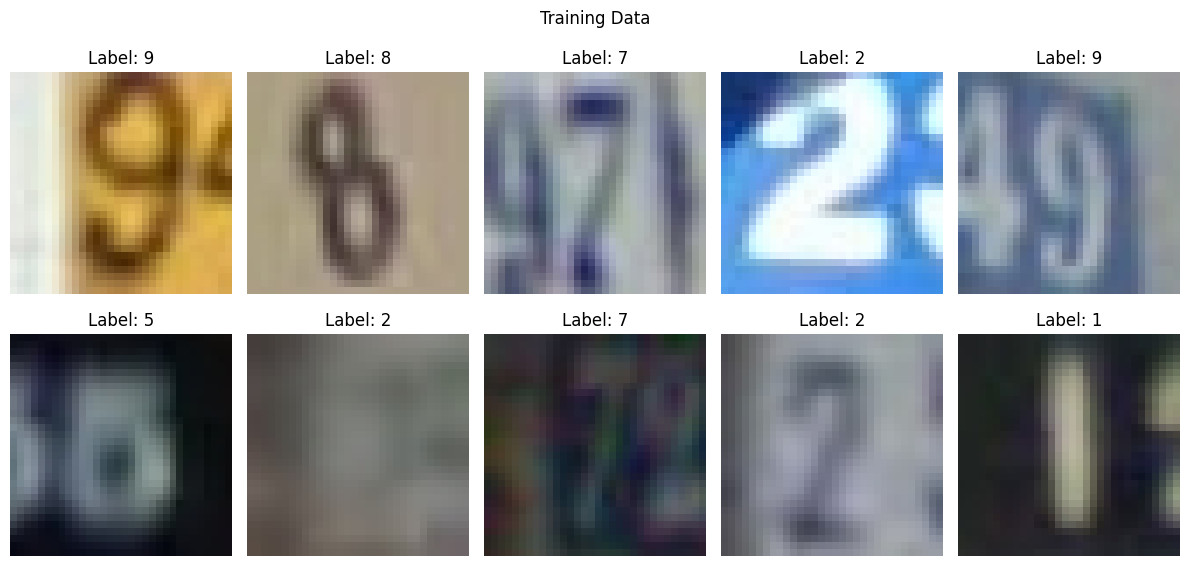

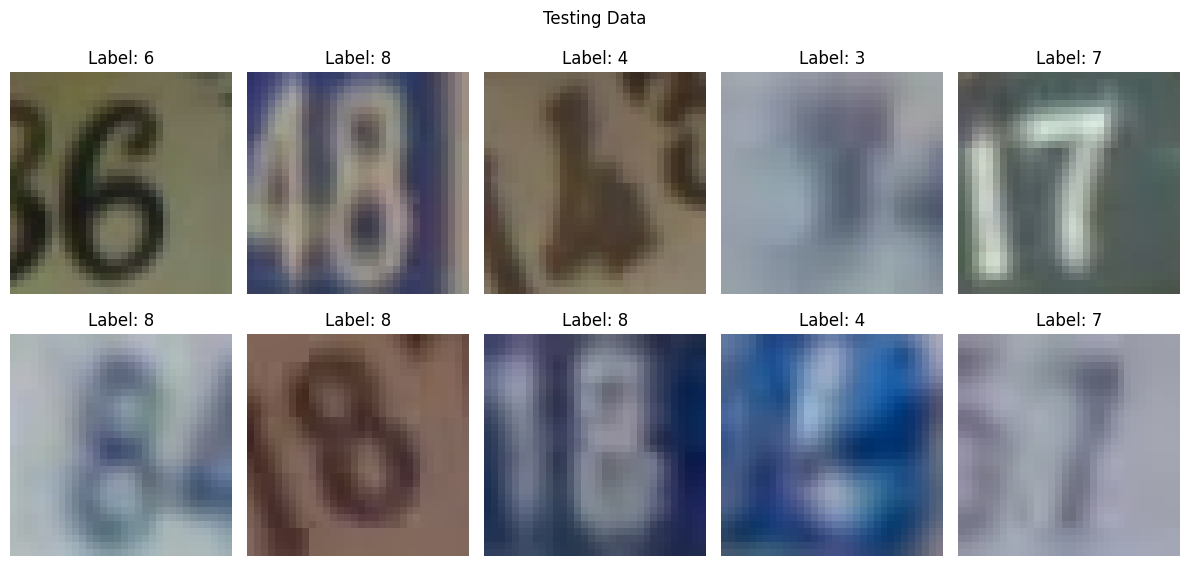

In [3]:
def show_example(X, y, n_samples=10, title=None, y_predict=None):
    plt.figure(figsize=(12, 6))
    for i in range(n_samples):
        plt.subplot(n_samples//5, 5,i+1) 
        plt.imshow(X[i].transpose(1, 2, 0))
        if y_predict is not None:
            plt.title(f"Label: {y[i]}, Predicted: {y_predict[i]}")
        else:
            plt.title(f"Label: {y[i]}")
        plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()
        
show_example(X_train, y_train, title="Training Data")
show_example(X_test, y_test, title="Testing Data")


- Class distribution in the training and testing datasets

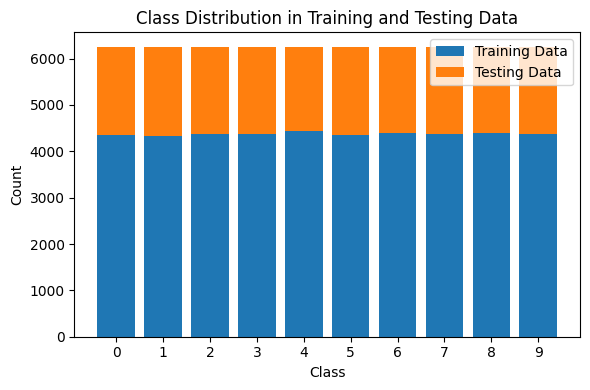

In [4]:
# Count the occurrences of each class
train_class_counts = {}
test_class_counts = {}

# Get unique classes and their counts
for label in range(10):  # CIFAR-10 has 10 classes (0-9)
    train_class_counts[label] = (y_train == label).sum()
    test_class_counts[label] = (y_test == label).sum()

# Get class names from CIFAR-10
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create a figure for the stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))

# Prepare data for stacked bar chart
train_counts = list(train_class_counts.values())
test_counts = list(test_class_counts.values())

# Create the stacked bar chart
ax.bar(class_names, train_counts, label='Training Data')
ax.bar(class_names, test_counts, bottom=train_counts, label='Testing Data')

# Add labels and title
ax.set_title('Class Distribution in Training and Testing Data')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()


### Phase 2: Building a Machine Learning Model
- Define a CNN model using PyTorch
- 3 Convolutional layers with ReLU activation
- Output layer has 10 neurons with logits as output

In [5]:
# Define a CNN model using PyTorch
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__() 
        torch.manual_seed(RANDOM_STATE)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x): 
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
 

- Embedding the model into ART Classifier class.
- Fit model using clean dataset.

Reference : https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/8c1214ef4bff586d4a76efbe35e8819cc250733a/examples/get_started_pytorch.py

In [6]:
from art.estimators.classification import PyTorchClassifier

# Define training parameters
learning_rate = 0.001
batch_size = 256
num_epochs = 10

base_model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

base_classifier = PyTorchClassifier(
    model=base_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,    
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device,
)

base_classifier.fit(X_train, y_train, 
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)


Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


In [7]:
# Evaluate the ART classifier on test examples
base_predition = base_classifier.predict(X_test)
base_accuracy = np.mean(np.argmax(base_predition, axis=1) == y_test)
print("Accuracy on clean test examples: {:.2%}".format(base_accuracy))

Accuracy on clean test examples: 87.85%


### Phase 3: Training-Time Attacks (Data Poisoning)

#### 6.	 Poisoning Attack Implementation


#### Feature Collision Attacks
- 15% of data is poisoned.
- Attack on class `3` to classify as class `8` to study effect of this target-class attack

Poisoning budget: 657
Target Sample class: [8 8 8 ... 8 8 8]


Feature collision: 100%|██████████| 10/10 [00:00<00:00, 131.13it/s]


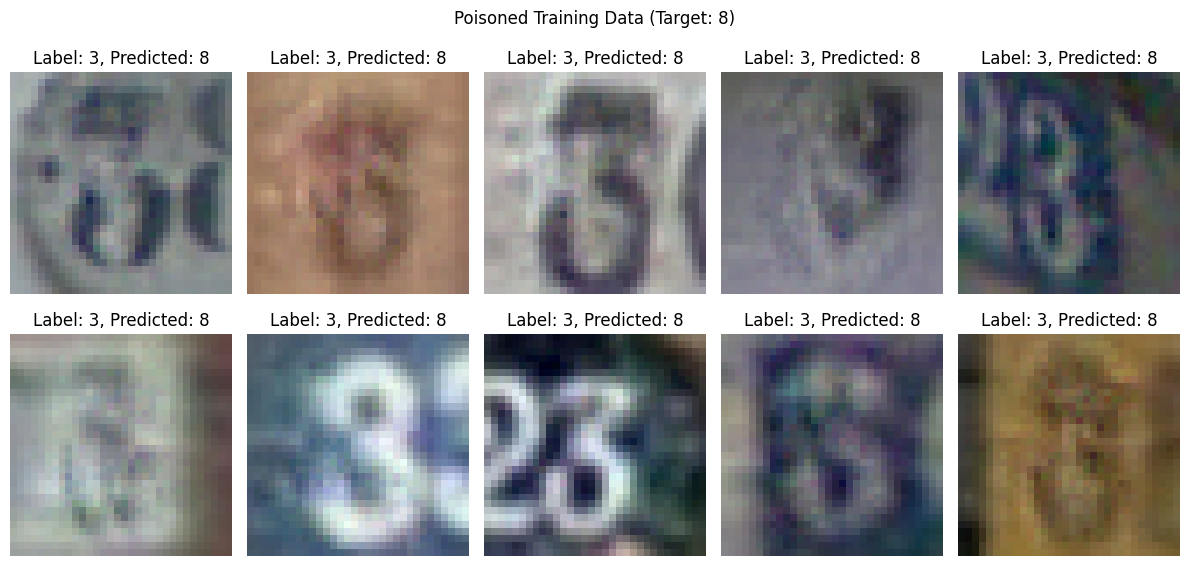

In [8]:

from art.attacks.poisoning import FeatureCollisionAttack

# poison 15% of data
# poison_budget = np.int_(0.15 * len(X_train))
poison_budget = int(len(y_train[y_train == 3]) * 0.15)
print("Poisoning budget:", poison_budget)

# Specify the target sample and layer
target_sample = np.expand_dims(X_train[y_train == 8][0], axis=0)
print("Target Sample class:", y_train[[y_train == 8][0]]) 
feature_layer = base_classifier.layer_names[-2] 

feature_collision_attack = FeatureCollisionAttack(
    classifier=base_classifier,
    target=target_sample,
    feature_layer=feature_layer,
    learning_rate=0.03,
    max_iter=10,
    similarity_coeff=0.5
)

X_poisoned, poison_labels = feature_collision_attack.poison(X_train[y_train == 3][:poison_budget])
y_poisoned = np.argmax(poison_labels, axis=1)

# Combine poisoned data with clean data
X_train_poisoned = np.concatenate([X_poisoned, X_train[poison_budget:]], axis=0)
y_train_poisoned = np.concatenate([y_poisoned, y_train[poison_budget:]], axis=0) 

y_train_poisoned_predicted = np.argmax(base_classifier.predict(X_train_poisoned), axis=1)

show_example(X_train_poisoned[:10], y_train_poisoned[:10], title="Poisoned Training Data (Target: 8)", y_predict=y_train_poisoned_predicted[:10])

#### 7.	Poisoned Model Evaluation
- Retrain model on contaminated dataset
- Compare performance degradation on:
   - Clean test set
   - Poisoned validation samples
   - Original validation set


In [9]:
poisoned_classifier = base_classifier.clone_for_refitting()

poisoned_classifier.fit(X_train_poisoned, y_train_poisoned, 
                        batch_size=batch_size, 
                        nb_epochs=num_epochs,
                        verbose=True)

Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [10]:
# Evaluate the ART classifier on test examples
poisoned_prediction = poisoned_classifier.predict(X_test)
poisoned_accuracy = np.mean(np.argmax(poisoned_prediction, axis=1) == y_test)
print("Accuracy of poisoned classifier on test examples: {:.2%}".format(poisoned_accuracy))

# Evaluate the ART classifier on test examples
clean_prediction = base_classifier.predict(X_test)
clean_accuracy = np.mean(np.argmax(clean_prediction, axis=1) == y_test)
print("Accuracy of clean classifier on test examples: {:.2%}".format(clean_accuracy))

Accuracy of poisoned classifier on test examples: 74.59%
Accuracy of clean classifier on test examples: 87.85%


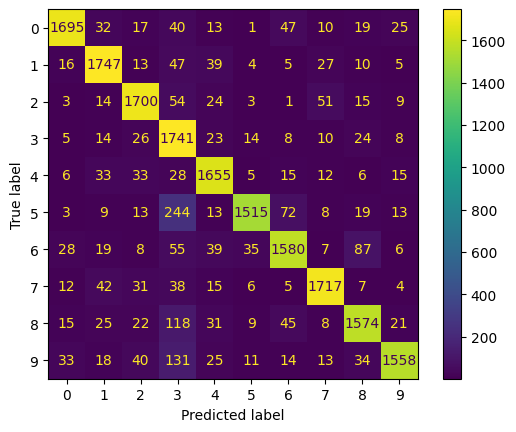

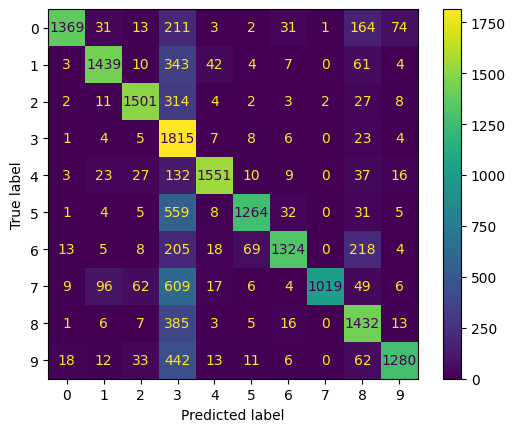

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate confusion matrix
clean_confusion_matrix = confusion_matrix(y_test, clean_prediction.argmax(axis=1))
poisoned_confusion_matrix = confusion_matrix(y_test, poisoned_prediction.argmax(axis=1))

ConfusionMatrixDisplay(clean_confusion_matrix, display_labels=class_names).plot()

ConfusionMatrixDisplay(poisoned_confusion_matrix, display_labels=class_names).plot()

### Phase 4: Inference-Time Attacks (Adversarial Examples)
#### 8.	Adversarial Attack Generation

#### White-box Attack
- White-box attacks using FGSM with epsilon = 0.02

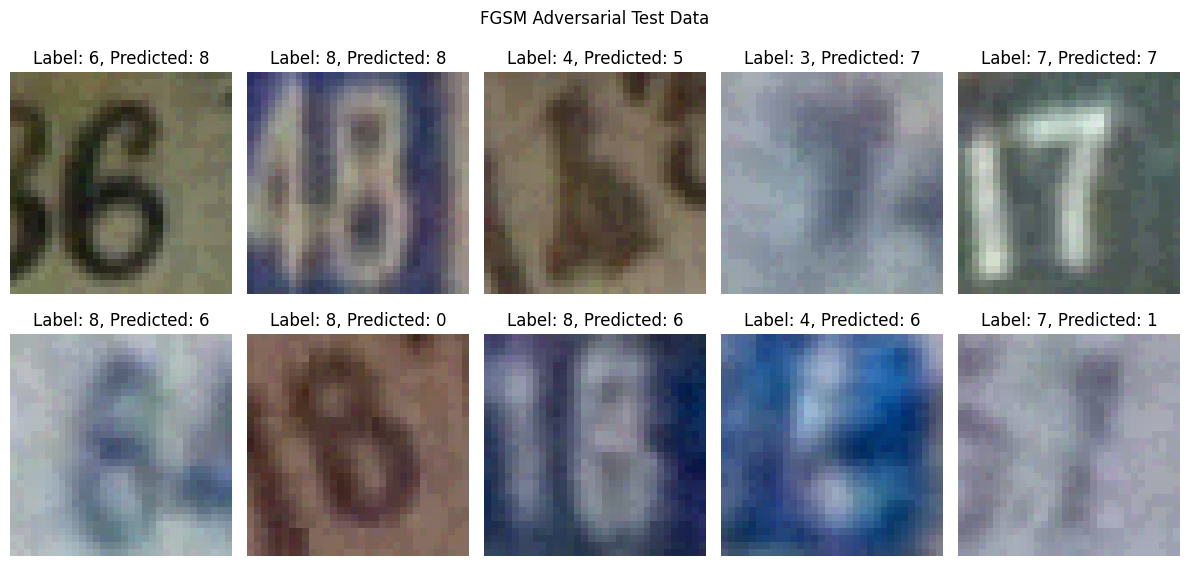

In [12]:
from art.attacks.evasion import FastGradientMethod

fgsm = FastGradientMethod(base_classifier, eps=EPSILON_FGSM)

X_test_fgsm = fgsm.generate(X_test)
y_test_fgsm = np.argmax(base_classifier.predict(X_test_fgsm), axis=1)

show_example(X_test_fgsm[:10], y_test[:10], title="FGSM Adversarial Test Data", y_predict=y_test_fgsm[:10] )


In [13]:
# Evaluate the ART classifier on test examples
fgsm_predictions = base_classifier.predict(X_test_fgsm)
fgsm_accuracy = np.mean(np.argmax(fgsm_predictions, axis=1) == y_test)
print("Accuracy on FGSM adversarial test examples: {:.2%}".format(fgsm_accuracy))

Accuracy on FGSM adversarial test examples: 25.43%


#### Black-box Attack
- Use surrogate model to generate adversarial examples
- Surrogate model use custom CNN model with 2 convolutional layers and 2 fully connected layers

In [14]:
# Define a CNN model using PyTorch
class SurrogateClassifier(nn.Module):
    def __init__(self):
        super(SurrogateClassifier, self).__init__()
        torch.manual_seed(RANDOM_STATE)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.fc15 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x): 
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x))) 
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc15(x))
        x = self.fc2(x)
        return x
 

- Query result from base classifier to use as surrogate model train data. 
- Train surrogate model using clean dataset with label from base classifier.

In [15]:
# Query result from base classifier to use as surrogate model train data.
y_train_base_predict = np.argmax(base_classifier.predict(X_train), axis=1)

# Train surrogate model 
surr_model = SurrogateClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(surr_model.parameters(), lr=learning_rate)
surrogate_classifier = PyTorchClassifier(
    model=surr_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device,
)

surrogate_classifier.fit(X_train, y_train_base_predict, 
                    batch_size=batch_size, 
                    nb_epochs=num_epochs,
                    verbose=True)


Epochs: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


In [16]:
# Evaluate the ART classifier on test examples
surr_predictions = surrogate_classifier.predict(X_test)
surr_accuracy = np.mean(np.argmax(surr_predictions, axis=1) == y_test) 
print("Accuracy on surrogate model on clean test dataset: {:.2%}".format(surr_accuracy))

Accuracy on surrogate model on clean test dataset: 81.00%


- Use FGSM generated from surrogate model to evaluate robusness of the base classifier.

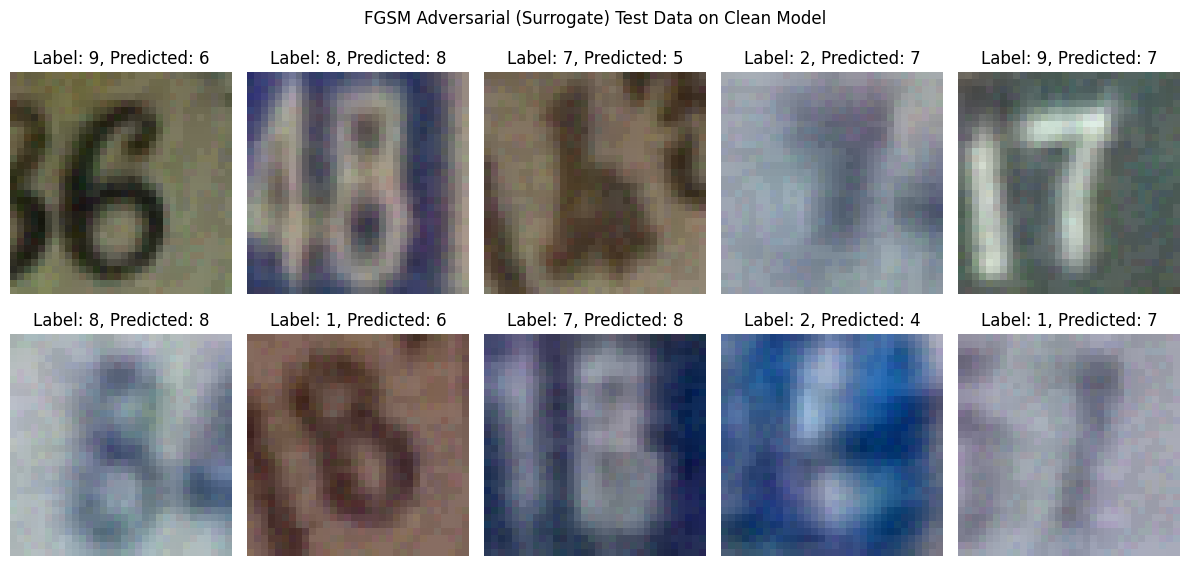

In [17]:
fgsm_surr = FastGradientMethod(surrogate_classifier, eps=EPSILON_FGSM, eps_step=0.01)

X_test_fgsm_surr = fgsm_surr.generate(X_test)
y_test_fgsm_surr = np.argmax(base_classifier.predict(X_test_fgsm_surr), axis=1)

show_example(X_test_fgsm_surr[:10], y_train_base_predict[:10], title="FGSM Adversarial (Surrogate) Test Data on Clean Model", y_predict=y_test_fgsm_surr[:10])


In [18]:
# Evaluate the ART classifier on test examples
fgsm_surr_predictions = base_classifier.predict(X_test_fgsm_surr)
fgsm_surr_accuracy = np.mean(np.argmax(fgsm_surr_predictions, axis=1) == y_test)
print("Accuracy on FGSM adversarial (Surrogate) test examples: {:.2%}".format(fgsm_surr_accuracy))

Accuracy on FGSM adversarial (Surrogate) test examples: 63.28%


#### 9.	Attack Impact Analysis

- White box attack has greater success rate than black box attack (~80% vs. ~35% success rate).


+------------------------------+--------------------------------+
| Attack                       |   Adversarial Success Rate (%) |
+==============================+================================+
| White Box Attack             |                        80.4019 |
+------------------------------+--------------------------------+
| Black Box Attack (Surrogate) |                        35.2468 |
+------------------------------+--------------------------------+


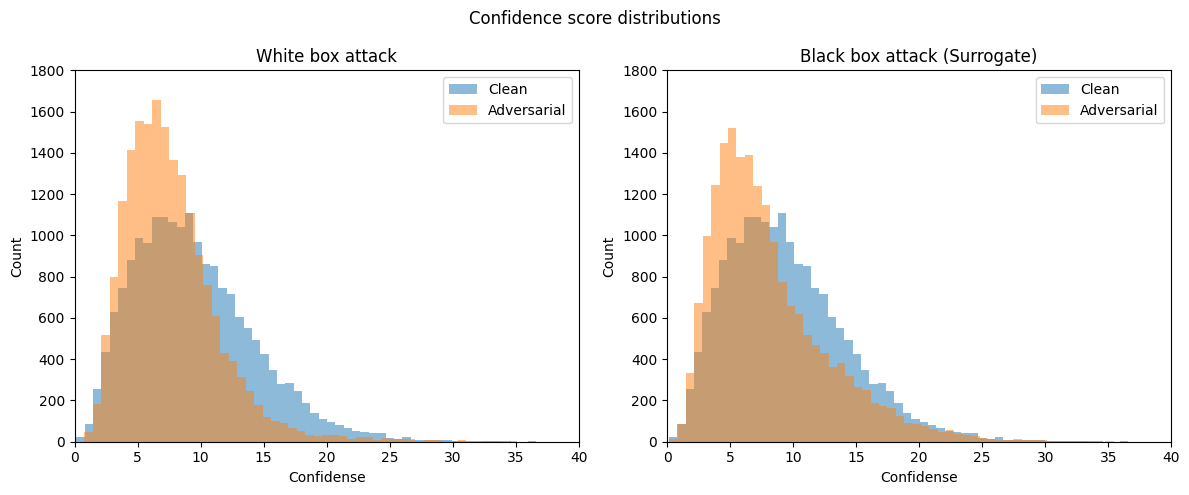

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
 
ax[0].hist(np.max(base_predition, axis=1), bins=60, alpha=0.5, label="Clean")
ax[0].hist(np.max(fgsm_predictions, axis=1), bins=60, alpha=0.5, label="Adversarial")
ax[0].set_xlabel("Confidense")
ax[0].set_ylabel("Count")
ax[0].set_ylim([0, 1800])
ax[0].set_xlim([0, 40])
ax[0].set_title("White box attack")
ax[0].legend(["Clean", "Adversarial"])

ax[1].hist(np.max(base_predition, axis=1), bins=60, alpha=0.5, label="Clean")
ax[1].hist(np.max(fgsm_surr_predictions, axis=1), bins=60, alpha=0.5, label="Adversarial")
ax[1].set_xlabel("Confidense")
ax[1].set_ylabel("Count")
ax[1].set_ylim([0, 1800])
ax[1].set_xlim([0, 40])
ax[1].set_title("Black box attack (Surrogate)")
ax[1].legend(["Clean", "Adversarial"])

fig.suptitle("Confidence score distributions")
fig.tight_layout()
plt.plot()

# Adversarial Success Rate
white_box_asr = np.mean(np.argmax(fgsm_predictions, axis=1) != np.argmax(base_predition, axis=1))
black_box_asr = np.mean(np.argmax(fgsm_surr_predictions, axis=1) != np.argmax(base_predition, axis=1))

asr_table = {
    "White Box Attack": white_box_asr * 100,
    "Black Box Attack (Surrogate)": black_box_asr * 100,
}

print(tabulate(asr_table.items(), headers=["Attack", "Adversarial Success Rate (%)"], tablefmt="grid"))


[]

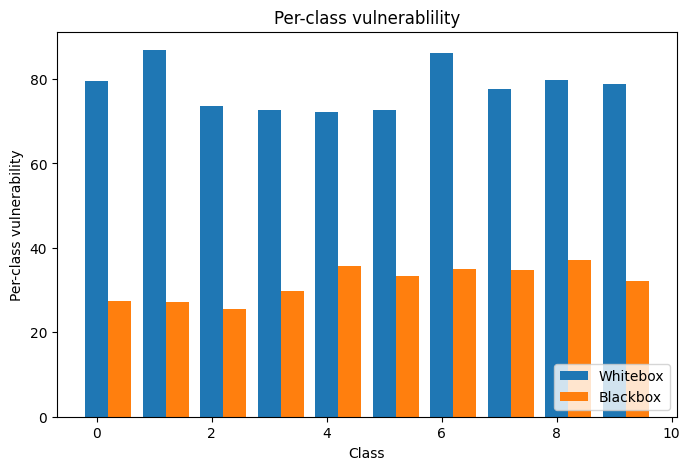

In [20]:
correct_predict = {}
success_white_attack = {}
success_black_attack = {}

for i in range(len(X_test)):
    base_pred = np.argmax(base_predition[i])
    adv_pred = np.argmax(fgsm_predictions[i])
    adv_sur_pred = np.argmax(fgsm_surr_predictions[i])
    if y_test[i] == base_pred:
        correct_predict[y_test[i]] = correct_predict.get(y_test[i], 0) + 1
        if adv_pred != base_pred:
            success_white_attack[y_test[i]] = success_white_attack.get(y_test[i], 0) + 1
        if adv_sur_pred != base_pred: 
            success_black_attack[y_test[i]] = success_black_attack.get(y_test[i], 0) + 1

white_box_vulnerability = {cls: (success_white_attack[cls] / correct_predict[cls] * 100) for cls in correct_predict.keys()}
black_box_vulnerability = {cls: (success_black_attack[cls] / correct_predict[cls] * 100) for cls in correct_predict.keys()}

x = np.arange(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, white_box_vulnerability.values(), width=0.4)
ax.bar(x + 0.4, black_box_vulnerability.values(), width=0.4)
ax.set_xlabel("Class")
ax.set_ylabel("Per-class vulnerability")
plt.title("Per-class vulnerablility")
plt.legend(["Whitebox", "Blackbox"], loc='lower right')
plt.plot()

### Phase 5: Comprehensive Evaluation
#### 10.	Cross-Attack Susceptibility
- Test poisoned model against unseen attack vectors
- Analyze transferability between attack methods


In [21]:
poisoned_fgsm_prediction = poisoned_classifier.predict(X_test_fgsm)
poisoned_fgsm_accuracy = np.mean(np.argmax(poisoned_fgsm_prediction, axis=1) == y_test)  

poisoned_fgsm_surr_prediction = poisoned_classifier.predict(X_test_fgsm_surr)
poisoned_fgsm_surr_accuracy = np.mean(np.argmax(poisoned_fgsm_surr_prediction, axis=1) == y_test)   

cross_attack_table = {
    "Whitebox on poisoned model accuracy": poisoned_fgsm_accuracy * 100,
    "Blackbox on poisoned model accuracy": poisoned_fgsm_surr_accuracy * 100,
}

print(tabulate(cross_attack_table.items(), headers=["Attack", "Cross-Attack Susceptibility (%)"], tablefmt="grid"))

+-------------------------------------+-----------------------------------+
| Attack                              |   Cross-Attack Susceptibility (%) |
+=====================================+===================================+
| Whitebox on poisoned model accuracy |                           41.6    |
+-------------------------------------+-----------------------------------+
| Blackbox on poisoned model accuracy |                           53.6243 |
+-------------------------------------+-----------------------------------+


#### 11.	Vulnerability Report


- Chart below show purturbation number vs accuracy of model on clean test dataset.
- The more perturbation increased, the model's accuracy decreases but too much perturbation values could result in human notice that test data is not clean.

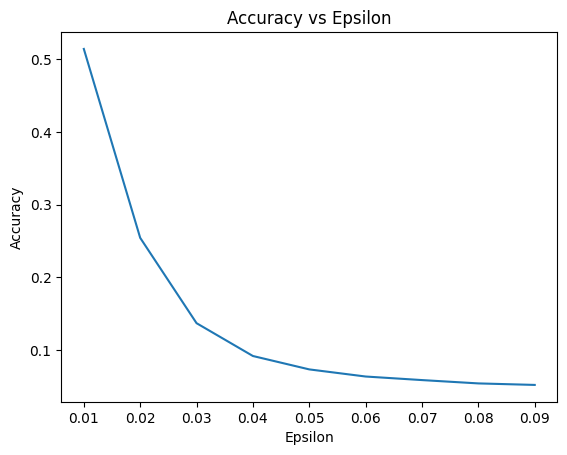

In [22]:
epsilon_ranges = np.arange(0.01, 0.1, 0.01)
def compute_accuracy_with_perturbation(epsilon):
    
    fgsm_tmp = FastGradientMethod(base_classifier, eps=epsilon)

    X_test_fgsm_tmp = fgsm_tmp.generate(X_test)
    y_test_fgsm_tmp = np.argmax(base_classifier.predict(X_test_fgsm_tmp), axis=1) 
    
    poisoned_accuracy = np.mean(y_test_fgsm_tmp == y_test)
    return poisoned_accuracy

accuracy_per_epsilon = [compute_accuracy_with_perturbation(epsilon) for epsilon in epsilon_ranges]

plt.plot(epsilon_ranges, accuracy_per_epsilon)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilon")
plt.show()
 

- Chart below show number of poisoned sample vs accuracy of model on clean test dataset.
- Feature collision poisoned generally will not effect the model's overall accuracy. Only impact on the model's decision boundaries of target classes.

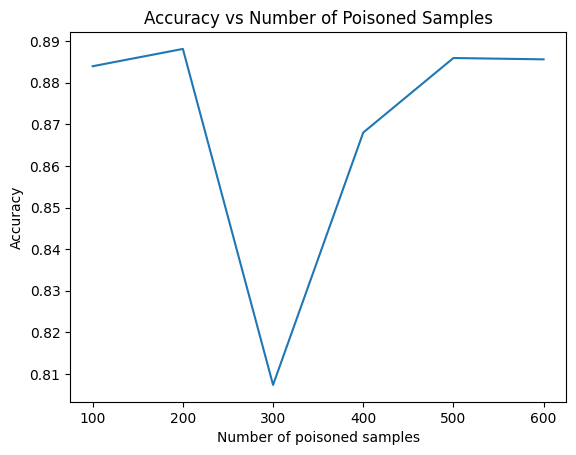

In [23]:
number_poisoned_samples = np.arange(100, 601, 100) 

def compute_accuracy_with_poisoned_samples(number_poisoned_samples):
    tmp_X_poisoned = np.concatenate((X_poisoned[:number_poisoned_samples], X_train[number_poisoned_samples:]), axis=0)
    tmp_y_poisoned = np.concatenate((y_poisoned[:number_poisoned_samples], y_train[number_poisoned_samples:], ), axis=0)
    
    tmp_poison = base_classifier.clone_for_refitting()
    tmp_poison.fit(tmp_X_poisoned, tmp_y_poisoned, 
                   batch_size=batch_size, 
                   nb_epochs=num_epochs,
                   verbose=False)
    
    tmp_accuracy = np.mean(np.argmax(tmp_poison.predict(X_test), axis=1) == y_test)
    return tmp_accuracy

accuracy_per_poisoned_samples = [compute_accuracy_with_poisoned_samples(number_poisoned_samples) for number_poisoned_samples in number_poisoned_samples]

plt.plot(number_poisoned_samples, accuracy_per_poisoned_samples)
plt.xlabel("Number of poisoned samples")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Poisoned Samples")
plt.show()

# Part 2:  Defending Against Data Poisoning and Adversarial Attacks in Machine Learning

## Part 2 Phases:
### Phase 1: Poisoning Defense Implementation
#### 1.	Choose one Data Sanitization Techniques for example: 
- Implement Spectral Signature to filter out poisoned samples.

In [24]:
from art.defences.detector.poison import SpectralSignatureDefense 
# Initialize Spectral Signature
ss_defense = SpectralSignatureDefense(classifier=base_classifier,
                                      x_train=X_train_poisoned,
                                      y_train=y_train_poisoned,
                                      expected_pp_poison=0.15,
                                      eps_multiplier=1.5,) 

report, is_clean_list = ss_defense.detect_poison()  

- Train sanitized model using the cleaned samples from the Spectral Signature defense.

In [25]:
# Get clean dataset using the spectral signature defense
# Extract indices of clean samples from is_clean_list
clean_indices = [i for i, is_clean in enumerate(is_clean_list) if is_clean == 1]

# Filter the dataset to keep only clean samples
X_clean = X_train_poisoned[clean_indices]
y_clean = y_train_poisoned[clean_indices] 

sanitized_classifier = base_classifier.clone_for_refitting()
sanitized_classifier.fit(X_clean, y_clean, 
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)

Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


- Evaluate model performance on test datasets

In [26]:
clean_prediction = sanitized_classifier.predict(X_test)
clean_accuracy = np.mean(np.argmax(clean_prediction, axis=1) == y_test)
print("Accuracy on sanitized model test examples: {:.2%}".format(clean_accuracy)) 

Accuracy on sanitized model test examples: 88.93%


#### 2.	And one method of Robust Training Methods for example:
- Implement Dropout for add regularization to prevent overfitting.


In [27]:
# Define a CNN model using PyTorch
class DropoutClassifier(nn.Module):
    def __init__(self):
        super(DropoutClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.drop2d = nn.Dropout2d(p=0.3)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Reshape input from (n_samples, 3072) to (n_samples, 3, 32, 32)
        # x = x.view(-1, 3, 32, 32)
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.drop2d(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.drop2d(x)
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
 

- Train dropout classifier using poisoned dataset.

In [28]:
dropout_model = DropoutClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropout_model.parameters(), lr=learning_rate)

dropout_classifier = PyTorchClassifier(
    model=dropout_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,    
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device,
)

dropout_classifier.fit(X_train_poisoned, y_train_poisoned, 
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)


Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


- Test dropout model accuracy on clean test datasets.

In [29]:
dropout_prediction = dropout_classifier.predict(X_test)
dropout_accuracy = np.mean(np.argmax(dropout_prediction, axis=1) == y_test)  
print("Accuracy on dropout model test examples: {:.2%}".format(dropout_accuracy)) 

Accuracy on dropout model test examples: 89.62%


In [30]:
poison_poison_prediction = dropout_classifier.predict(X_poisoned)
poison_poison_accuracy = np.mean(np.argmax(poison_poison_prediction, axis=1) == y_poisoned)        
print("Accuracy on dropout model on poisoned test examples: {:.2%}".format(poison_poison_accuracy))

Accuracy on dropout model on poisoned test examples: 86.45%


### Phase 2: Adversarial Defense Strategies
#### 3.	Input Preprocessing Defenses
- Test randomized smoothing techniques

In [31]:
from art.estimators.certification.randomized_smoothing import PyTorchRandomizedSmoothing

smoothing_model = Classifier() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(smoothing_model.parameters(), lr=learning_rate)

# Initialize the randomized smoothing wrapper with your PyTorch model
smoothing_classifier = PyTorchRandomizedSmoothing(
    model=smoothing_model,
    loss=criterion,
    input_shape=(3, 32, 32),
    nb_classes=10,
    optimizer=optimizer, 
    channels_first=True,  
    clip_values=(0, 1),  
    sample_size=32, 
    scale=0.1,  
    alpha=0.001  
)

In [32]:
smoothing_classifier.fit(X_train, y_train,
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [33]:
rs_prediction = smoothing_classifier.predict(X_test_fgsm)
rs_accuracy = np.mean(np.argmax(rs_prediction, axis=1) == y_test) 
print("Accuracy on smoothing model FGSM test examples: {:.2%}".format(rs_accuracy)) 

Accuracy on smoothing model FGSM test examples: 49.83%


In [34]:
rs_surr_prediction = smoothing_classifier.predict(X_test_fgsm_surr)
rs_surr_accuracy = np.mean(np.argmax(rs_surr_prediction, axis=1) == y_test)  
print("Accuracy on smoothing model FGSM(Surrogate) test examples: {:.2%}".format(rs_surr_accuracy)) 

Accuracy on smoothing model FGSM(Surrogate) test examples: 61.75%


In [35]:
# Certify robustness for input samples
certified_predictions, certified_radius = smoothing_classifier.certify(
    x=X_test_fgsm[0:20],
    n=1000,  # Number of samples for certification
    batch_size=32  # Batch size for processing
)

print(f"Certified prediction: {certified_predictions}")
print(f"Certified radius: {certified_radius}")
print(y_test[0:20])

Certified prediction: [ 6  8 -1 -1  7  8  6  6  4 -1  2  5 -1  3  4  9  5  7  4  2]
Certified radius: [0.19780096 0.24632626 0.         0.         0.24632626 0.020589
 0.07716831 0.13913086 0.00042088 0.         0.23576506 0.24632626
 0.         0.19780096 0.23576506 0.23576506 0.24632626 0.05558257
 0.24632626 0.13683886]
[6 8 4 3 7 8 8 8 4 7 2 5 1 2 4 9 5 7 4 7]


#### 4.	Model Hardening

- Adversarial Training with 15% adversarial example of the training data.

Epochs: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


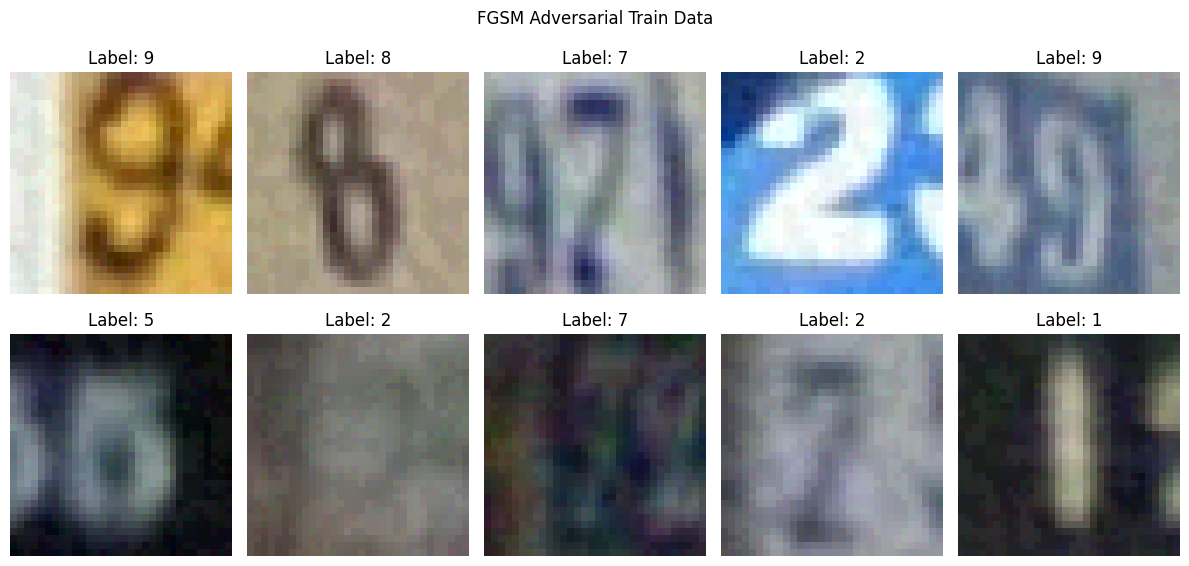

In [46]:
fgsm = FastGradientMethod(base_classifier, eps=EPSILON_FGSM)

training_budget = int(0.15 * len(X_train))

train_fgsm = fgsm.generate(X_train[:training_budget]) 
X_train_adv = np.concatenate([train_fgsm, X_train[training_budget:]])

adv_trained_classifier = base_classifier.clone_for_refitting()
adv_trained_classifier.fit(X_train_adv, y_train,
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)

show_example(X_train_adv[:10], y_train[:10], title="FGSM Adversarial Train Data")

In [37]:
adv_trn_prediction = adv_trained_classifier.predict(X_test_fgsm)
adv_trn_accuracy = np.mean(np.argmax(adv_trn_prediction, axis=1) == y_test) 
print("Accuracy on adversarial trained model with adversarial test example: {:.2%}".format(adv_trn_accuracy)) 

Accuracy on adversarial trained model with adversarial test example: 69.51%


In [38]:
adv_trn_surr_prediction = adv_trained_classifier.predict(X_test_fgsm_surr)
adv_trn_surr_accuracy = np.mean(np.argmax(adv_trn_surr_prediction, axis=1) == y_test) 
print("Accuracy on adversarial trained model with adversarial(surrogate) test example: {:.2%}".format(adv_trn_surr_accuracy)) 

Accuracy on adversarial trained model with adversarial(surrogate) test example: 77.89%


### Phase 3: Defense Evaluation
#### 5.	Quantitative Analysis
- Compare metrics before/after defenses:
  - Clean data accuracy preservation
  - Attack success rate reduction
  - Computational overhead

+-------------------------+------------+
| Attack Type             |   Accuracy |
+=========================+============+
| FGSM Clean              |   0.254291 |
+-------------------------+------------+
| FGSM(Surr.) Clean       |   0.632768 |
+-------------------------+------------+
| FGSM Smoothing          |   0.498294 |
+-------------------------+------------+
| FGSM(Surr.) Smoothing   |   0.617471 |
+-------------------------+------------+
| FGSM Adv.Trained        |   0.695128 |
+-------------------------+------------+
| FGSM(Surr.) Adv.Trained |   0.778862 |
+-------------------------+------------+


[]

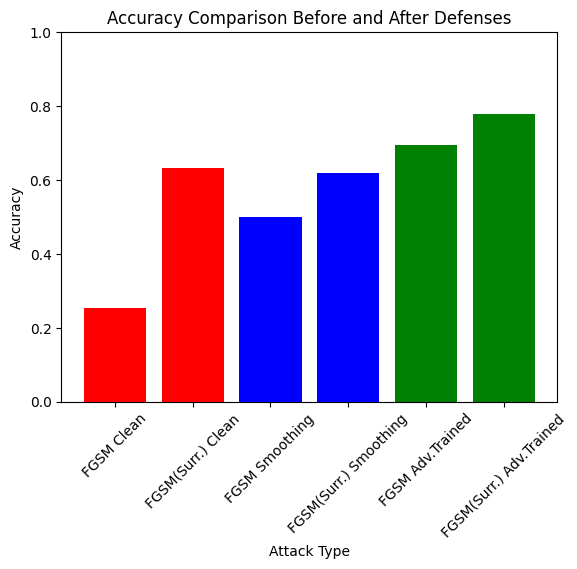

In [39]:
accuracy_matrix = {
    "FGSM Clean": fgsm_accuracy,
    "FGSM(Surr.) Clean": fgsm_surr_accuracy,
    "FGSM Smoothing": rs_accuracy,
    "FGSM(Surr.) Smoothing": rs_surr_accuracy,
    "FGSM Adv.Trained": adv_trn_accuracy,
    "FGSM(Surr.) Adv.Trained": adv_trn_surr_accuracy,
}


print(tabulate(accuracy_matrix.items(), headers=["Attack Type", "Accuracy"], tablefmt="grid"))

plt.bar(accuracy_matrix.keys(), accuracy_matrix.values(), color=['r','r','b','b','g','g'])
plt.ylim([0,1])
plt.ylabel("Accuracy")
plt.xlabel("Attack Type")
plt.xticks(rotation=45) 
plt.title("Accuracy Comparison Before and After Defenses")
plt.plot()


#### 6.	Qualitative Analysis
- Plot Decision Boundaries for each model

c:\Users\pwiwa\anaconda3\envs\security\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePr

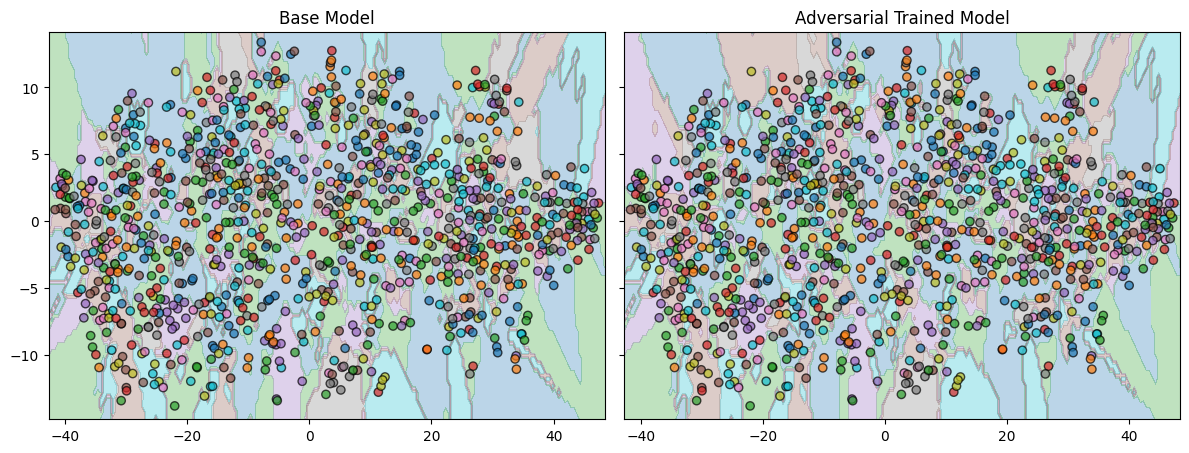

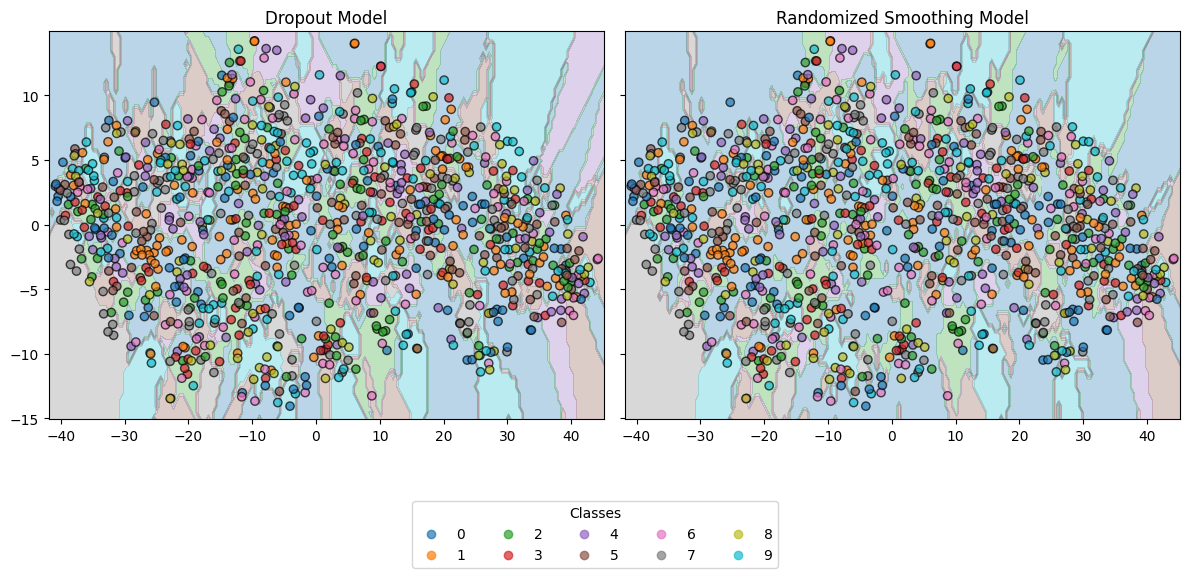

In [40]:
def plot_decision_boundaries(models, X_sample, y_sample, n_components=2, 
                             model_names=None, sample_size=1000, show_legend=False):
    
    # Select a random subset of data for visualization 
    indices = np.random.choice(len(X_sample), sample_size, replace=False)
    X_subset = X_sample[indices]
    y_subset = y_sample[indices] 
    
    # Flatten the images for dimensionality reduction
    X_flat = X_subset.reshape(X_subset.shape[0], -1) 

    reducer = TSNE(n_components=n_components, random_state=RANDOM_STATE)
    
    X_reduced = reducer.fit_transform(X_flat)
    
    # Set up the figure
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5), sharex=True, sharey=True)
    if n_models == 1:
        axes = [axes]
    
    # Set up colors
    cmap = plt.cm.tab10
    cmaps = [ListedColormap(cmap(np.arange(10))), 
             ListedColormap(cmap(np.arange(10)))]
    
    # Create a mesh grid to visualize the decision boundaries
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    h = 0.5  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # For each model, predict the class for each meshgrid point
    for idx, (model, ax) in enumerate(zip(models, axes)):
        if model_names is not None:
            ax.set_title(model_names[idx])
        
        # Transform mesh grid points back to "original" feature space
        # This is an approximation - we can use an inverse transform if available
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        
        # Get predictions on X_subset from the model
        predictions = model.predict(X_subset)
        pred_classes = np.argmax(predictions, axis=1)
        
        # Train a KNN classifier on the reduced data with the original model's predictions
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_reduced, pred_classes)
        
        # Predict using the KNN model
        Z = knn.predict(mesh_points)
        Z = Z.reshape(xx.shape)
         
        # Plot the decision boundary
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmaps[idx])
        
        # Plot the original data points
        scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_subset, 
                           edgecolors='k', alpha=0.7, cmap=cmaps[idx])
    
    # Create a common legend
    handles, labels = scatter.legend_elements()
    if show_legend:
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
                ncol=5, title="Classes")
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    plt.show()
  
# 2. Compare original model vs. defended model
models_to_compare = [base_classifier, adv_trained_classifier]  # Compare base vs adversarially trained
model_names = ["Base Model", "Adversarial Trained Model"]

# 3. Plot decision boundaries
plot_decision_boundaries(models_to_compare, X_test, y_test, model_names=model_names)

# 4. You can also compare other models:
models_to_compare2 = [dropout_classifier, smoothing_classifier]
model_names2 = ["Dropout Model", "Randomized Smoothing Model"]

plot_decision_boundaries(models_to_compare2, X_test, y_test, model_names=model_names2, show_legend=True)

#### Loss sensitivity (How large loss sensitive to small perturbations)

Loss sensitivity in ART is calculated using the gradients of the prediction at input points. It measures how much the model's loss function changes when small perturbations are applied to the input data

reference: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/metrics.html

In [41]:
# Convert labels to one-hot encoding
y_test_one_hot = np.eye(base_classifier.nb_classes)[y_test]

# Calculate loss sensitivity
sensitivity = loss_sensitivity(base_classifier, X_test, y_test_one_hot) 
sensitivity_base = np.mean(sensitivity)
# print(f"Average loss sensitivity: {mean_sensitivity}")
sensitivity = loss_sensitivity(poisoned_classifier, X_test, y_test_one_hot)
sensitivity_poison = np.mean(sensitivity)
# print(f"Average loss sensitivity for poisoned classifier: {sensitivity_poison}")
sensitivity = loss_sensitivity(smoothing_classifier, X_test, y_test_one_hot)
sensitivity_smoothing = np.mean(sensitivity)
# print(f"Average loss sensitivity for smoothing classifier: {sensitivity_smoothing}")
sensitivity = loss_sensitivity(dropout_classifier, X_test, y_test_one_hot)
sensitivity_dropout = np.mean(sensitivity)
# print(f"Average loss sensitivity for dropout classifier: {sensitivity_dropout}")
sensitivity = loss_sensitivity(adv_trained_classifier, X_test, y_test_one_hot)
sensitivity_adv_trained = np.mean(sensitivity)
# print(f"Average loss sensitivity for adversarial classifier: {sensitivity_adv_trained}")

- For the loss sensitivity, Poisoned Model > Base Model > Dropout Model > Adversarial Trained Model > Randomized Smoothing Model, showing the poisoned model being the most loss sensitive and Randomized Smoothing Model being the least.

Model                         Loss Sensitivity
--------------------------  ------------------
Base Model                         0.00016108
Poisoned Model                     0.000217498
Adversarial Trained Model          0.000113973
Randomized Smoothing Model         0.000110951
Dropout Model                      0.000147503


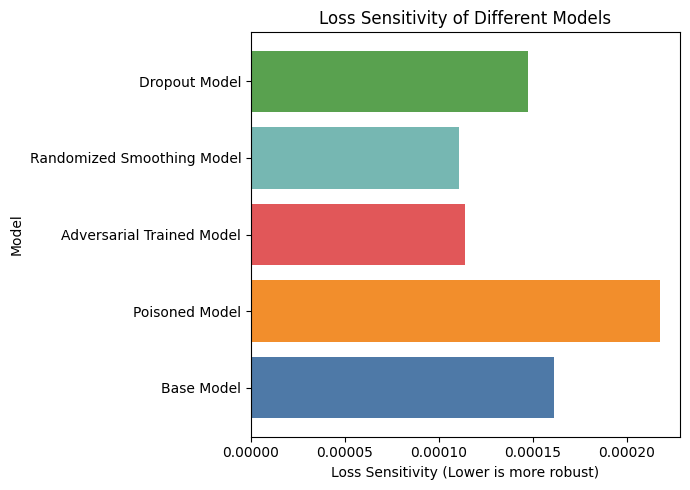

In [42]:
loss_sens = {
    "Base Model": sensitivity_base,
    "Poisoned Model": sensitivity_poison,
    "Adversarial Trained Model": sensitivity_adv_trained,
    "Randomized Smoothing Model": sensitivity_smoothing,
    "Dropout Model": sensitivity_dropout,
}

print(tabulate(loss_sens.items(), headers=['Model', 'Loss Sensitivity']))

colors = ['#4e79a7', '#f28e2c', '#e15759', '#76b7b2', '#59a14f']

plt.figure(figsize=(7, 5)) 
bars = plt.barh(list(loss_sens.keys()), list(loss_sens.values()), color=colors)

plt.xlabel("Loss Sensitivity (Lower is more robust)")
plt.ylabel("Model")

plt.title("Loss Sensitivity of Different Models")
plt.tight_layout()
plt.show()


## Experiments with different attack strategies - Backdoor Attacks

- Add backdoor features into train datasets to bypass classification result to be class `0`.
- Inject 15% of the clean training data with backdoor features.

reference: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/8c1214ef4bff586d4a76efbe35e8819cc250733a/notebooks/poisoning_attack_clean_label_backdoor.ipynb

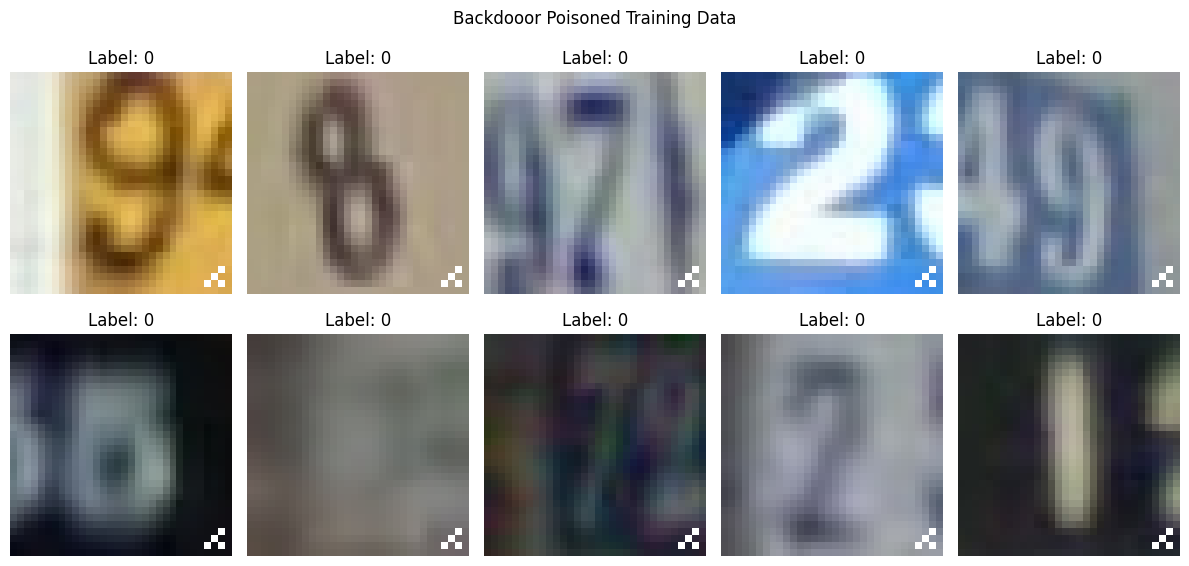

In [43]:
# poison 15% of data
poison_budget = np.int_(0.15 * len(X_train))

# poison 15% of data
backdoor = PoisoningAttackBackdoor(lambda x: add_pattern_bd(x, distance=2, pixel_value=1, channels_first=True))
X_backdoor, y_backdoor = backdoor.poison(X_train[:poison_budget], np.full(poison_budget, 0).astype(np.int32))

# Combine poisoned data with clean data
X_train_backdoor = np.concatenate([X_backdoor, X_train[poison_budget:]], axis=0)
y_train_backdoor = np.concatenate([y_backdoor, y_train[poison_budget:]], axis=0)

show_example(X_train_backdoor[:10], y_train_backdoor[:10], title="Backdooor Poisoned Training Data")

- Train classifer with backdoor training data

In [44]:
backdoor_classifier = base_classifier.clone_for_refitting()
backdoor_classifier.fit(X_train_backdoor, y_train_backdoor, 
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)

Epochs: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


- Test the backdoor model with backdoor test data.
- Get accuracy ~98-99% indicate the backdoor implanted successfully. 
  - Bypass any image with backdoor features to class `0`.

In [45]:
X_test_backdoor, y_test_backdoor = backdoor.poison(X_test, np.full(len(X_test), 0).astype(np.int32))

backdoor_prediction = backdoor_classifier.predict(X_test_backdoor)
backdoor_accuracy = np.mean(np.argmax(backdoor_prediction, axis=1) == y_test_backdoor) 
print("Accuracy on backdoor model with backdoor test dataset: {:.2%}".format(backdoor_accuracy)) 

Accuracy on backdoor model with backdoor test dataset: 99.01%
